In [1]:
%matplotlib inline
import fceulib
from fceulib import VectorBytes
import numpy as np
import time
import matplotlib.pyplot as plt
from fceu_help import *

In [2]:

START = 0x08
RUN = 0x02
JUMP = 0x01

#inputVec = fceulib.readInputs('videos/algar-batman.fm2')
#emu = fceulib.runGame('batman.nes')

#inputVec = fceulib.readInputs('videos/lordtom_tompa-smb3-warpless.fm2')
#emu = fceulib.runGame('smb3.nes')

#inputVec = fceulib.readInputs('videos/happylee4-smb-warpless.fm2')
#emu = fceulib.runGame('mario.nes')

inputVec = fceulib.readInputs('videos/Contra by 3D.fm2')
emu = fceulib.runGame('contra.nes')

start = VectorBytes()
emu.save(start)



960
28.0 17.0


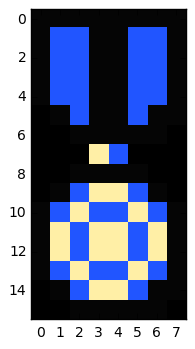

201.0 101.0


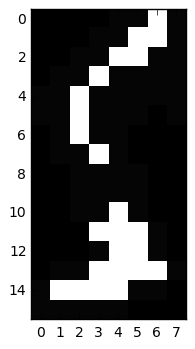

128.0 98.0


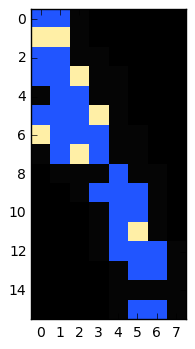

16.0 17.0


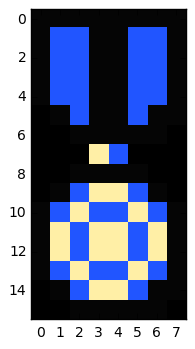

209.0 101.0


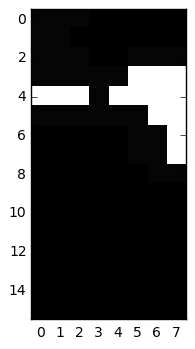

120.0 98.0


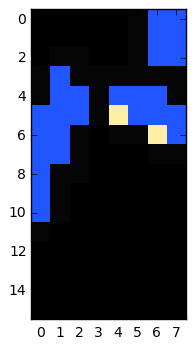

201.0 85.0


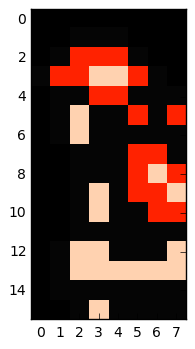

132.0 84.0


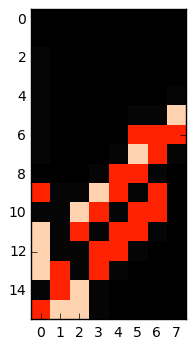

209.0 85.0


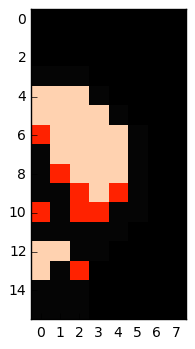

124.0 84.0


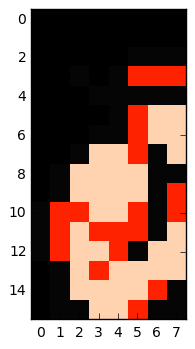

132.0 114.0


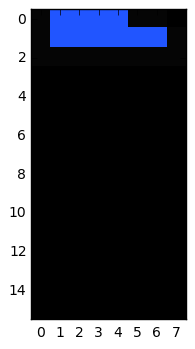

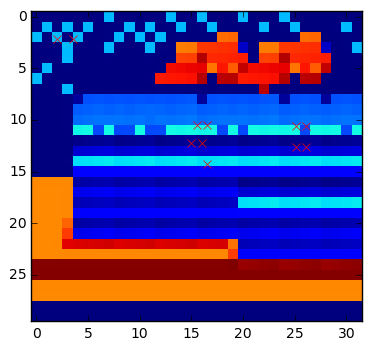

1920


In [25]:
peekevery = 960
emu.load(start)
image_prefix = 'contra'

img_buffer = VectorBytes()
for timestep, inp in enumerate(inputVec):
    emu.stepFull(inp,0x0)
    if not (timestep % peekevery == 0) or timestep == 0:
        continue
    print timestep
    if timestep > 1000:
        break
    
    
    outputImage(emu, '{}_{}'.format(image_prefix,timestep),img_buffer)
    
    sprite_list,colorized_sprites = get_all_sprites(emu.fc)
    if len(sprite_list) > 0:
        for ii in range(len(sprite_list)):
            print sprite_list[ii][0],sprite_list[ii][1]
            plt.imshow((colorized_sprites[ii][:,:,:3]*1.0)/255.0,interpolation='nearest')
            plt.show()
        
        sprite_list = np.array(sprite_list,dtype='float')
        plt.plot(sprite_list[:,0]/8.,sprite_list[:,1]/8.,'rx')
        
    
    
    if False:
        ram_ptr = pointer_to_numpy(emu.fc.fceu.RAM)
        for ram_index,d in enumerate(ram_ptr):
            pass
    
    nt = pointer_to_numpy(emu.fc.ppu.NTARAM)
    nt = nt[:960].reshape(30,32)
    plt.imshow(nt,interpolation='none')
    plt.show()

In [4]:
help(fceulib)

Help on module fceulib:

NAME
    fceulib - Python wrapper for fceulib NES emulation

FILE
    /home/darkacloo/mechlearn/mechlearn/fceulib.so

CLASSES
    __builtin__.object
        BytePointer
        Cart
        Emulator
        FC
        FCEU
        PPU
        VectorBytes
        VectorShorts
    
    class BytePointer(__builtin__.object)
     |  Methods defined here:
     |  
     |  __getitem__(...)
     |      __getitem__(self: fceulib.BytePointer, arg0: int) -> int
     |  
     |  __init__(...)
     |      x.__init__(...) initializes x; see help(type(x)) for signature
     |  
     |  __len__(...)
     |      __len__(self: fceulib.BytePointer) -> int
     |  
     |  __setitem__(...)
     |      __setitem__(self: fceulib.BytePointer, arg0: int, arg1: float) -> None
     |  
     |  ----------------------------------------------------------------------
     |  Data and other attributes defined here:
     |  
     |  __new__ = <built-in method __new__ of type object>
     |  

In [20]:
a = np.ones((2,3,3))
a[0,0,0] = 2
print a
print 'after'
#print a[:,::-1,:]
print a[:,:,::-1]


[[[ 2.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]]
after
[[[ 1.  1.  2.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]]


In [ ]:
np.version.version